# Validating the performance of Multi-View KMeans with Conditionally Independent Views on More Complex Data

In [1]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
from mvlearn.cluster.mv_k_means import MultiviewKMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_covtype
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

RANDOM_SEED=10

##### Creating an artificial dataset where the conditional independence assumption between views holds

Here, we create an artificial dataset where the conditional independence assumption between
views, given the true labels, is enforced. Our artificial dataset is derived from the forest 
covertypes dataset from the scikit-learn package. This dataset is comprised of 7 different classes, with
with 54 different numerical features per sample. To create our artificial data, we will select 500 samples from
each of the first 6 classes in the dataset, and from these, construct 3 artificial classes with 
2 views each. <br>

In [2]:
def get_ci_data(num_samples=500):

    #Load in the vectorized news group data from scikit-learn package
    cov = fetch_covtype()
    all_data = np.array(cov.data)
    all_targets = np.array(cov.target)
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = [1, 2, 3]
    view2_classes = [4, 5, 6]
    
    #Create lists to hold data and labels for each of the classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(num_samples)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], num_samples)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample items from each of the selected classes in view2
    for class_num in view2_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], num_samples)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(num_samples * len(view1_classes))
    view1_data = np.vstack(view1_data)
    view2_data = np.vstack(view2_data)
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    magnitudes1 = np.linalg.norm(view1_data, axis=0)
    magnitudes2 = np.linalg.norm(view2_data, axis=0)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((1, -1))
    magnitudes2 = magnitudes2.reshape((1, -1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    return [view1_data, view2_data], labels


##### Creating a function to perform both single-view and multi-view kmeans clustering

In the following function, we will perform single-view kmeans clustering on the two views separately and on them concatenated together. We also perform multi-view clustering using the multi-view algorithm. We will also compare the performance of multi-view and single-view versions of kmeans clustering. We will evaluate the purity of the resulting clusters from each algorithm with respect to the class labels using the normalized mutual information metric.

In [3]:
def perform_clustering(seed, m_data, labels, n_clusters):
    #################Single-view kmeans clustering#####################
    # Cluster each view separately
    s_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=100)
    s_clusters_v1 = s_kmeans.fit_predict(m_data[0])
    s_clusters_v2 = s_kmeans.fit_predict(m_data[1])

    # Concatenate the multiple views into a single view
    s_data = np.hstack(m_data)
    s_clusters = s_kmeans.fit_predict(s_data)

    # Compute nmi between true class labels and single-view cluster labels
    s_nmi_v1 = nmi_score(labels, s_clusters_v1)
    s_nmi_v2 = nmi_score(labels, s_clusters_v2)
    s_nmi = nmi_score(labels, s_clusters)
    print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
    print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
    print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

    #################Multi-view kmeans clustering######################

    # Use the MultiviewKMeans instance to cluster the data
    m_kmeans = MultiviewKMeans(n_clusters=n_clusters, n_init=100, random_state=seed)
    m_clusters = m_kmeans.fit_predict(m_data)

    # Compute nmi between true class labels and multi-view cluster labels
    m_nmi = nmi_score(labels, m_clusters)
    print('Multi-view NMI Score: {0:.3f}\n'.format(m_nmi))
    
    return m_clusters

##### Creating a function to display data and the results of clustering


The following function plots both views of data given a dataset and corresponding labels.

In [4]:
def display_plots(pre_title, data, labels):
    
    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    dot_size=10
    ax[0].scatter(new_data[0][:, 0], new_data[0][:, 1],c=labels,s=dot_size)
    ax[0].set_title(pre_title + ' View 1')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)

    ax[1].scatter(new_data[1][:, 0], new_data[1][:, 1],c=labels,s=dot_size)
    ax[1].set_title(pre_title + ' View 2')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    plt.show()

##### Comparing the Performance of Multi-view and Single-view KMeans on our Dataset with Conditionally Independent Views

The co-Expectation Maximization framework (and co-training), relies on the fundamental assumption that data views are conditionally independent. If all views are informative and conditionally independent, then Multi-view KMeans is expected to produce higher quality clusters than Single-view KMeans, for either view or for both views concatenated together. Here, we will evaluate the quality of clusters by using the normalized mutual information metric, which is essentially a measure of the purity of clusters with respect to the true underlying class labels. <br>

As we see below, Multi-view KMeans produces clusters with higher purity than Single-view KMeans across a range of values for the n_clusters parameter for data with complex and informative views, which is consistent with some of the results from the original Multi-view clustering paper.

Single-view View 1 NMI Score: 0.369

Single-view View 2 NMI Score: 0.375

Single-view Concatenated NMI Score: 0.644

Multi-view NMI Score: 0.617



<Figure size 432x288 with 0 Axes>

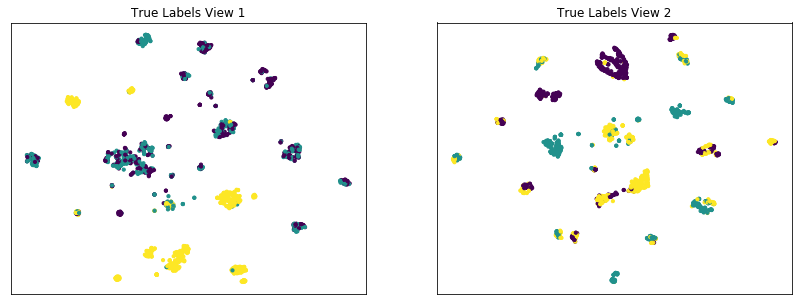

<Figure size 432x288 with 0 Axes>

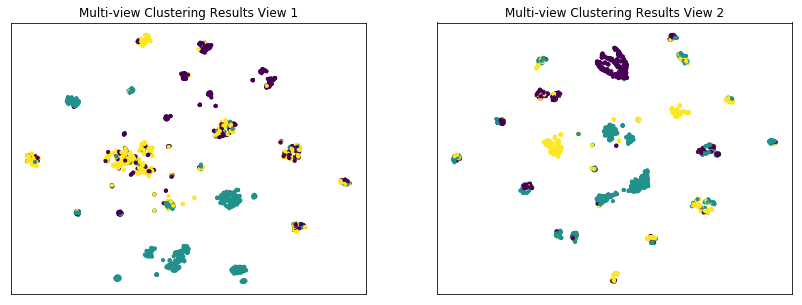

In [5]:
data, labels = get_ci_data()
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 3)

# Running TSNE to display clustering results via low dimensional embedding
tsne = TSNE()
new_data = list()
new_data.append(tsne.fit_transform(data[0]))
new_data.append(tsne.fit_transform(data[1]))
display_plots('True Labels', new_data, labels)
display_plots('Multi-view Clustering Results', new_data, m_clusters)

##### Creating an artificial dataset where the conditional independence assumption between views does not hold

Here, we create an artificial dataset where the conditional independence assumption between
views, given the true labels, is violated. We again derive our dataset from the forest covertypes 
dataset from sklearn. However, this time, we use only the first 3 classes of the dataset, which will
correspond to the 3 clusters for view 1. To produce view 2, we will apply a simple nonlinear transformation to view 1 
using the logistic function, and we will apply a negligible amount of noise to the second view to avoid convergence
issues. This will result in a dataset where the correspondance between views is very high.

In [6]:
def get_cd_data(num_samples=500):
    
    #Load in the vectorized news group data from scikit-learn package
    cov = fetch_covtype()
    all_data = np.array(cov.data)
    all_targets = np.array(cov.target)
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = [1, 2, 3]
    view2_classes = [4, 5, 6]
    
    #Create lists to hold data and labels for each of the classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(num_samples)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 500 items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], num_samples)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Construct view 2 by applying a nonlinear transformation
    #to data from view 1 comprised of a linear transformation
    #and a logistic nonlinearity
    t_mat =  np.random.random((view1_data.shape[1], 50)) 
    noise = 0.005 - 0.01*np.random.random((view1_data.shape[1], 50))
    t_mat *= noise
    transformed = view1_data @ t_mat
    view2_data = scp.special.expit(transformed)
    
    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(num_samples * len(view1_classes))
    view1_data = np.vstack(view1_data)
    view2_data = np.vstack(view2_data)
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    magnitudes1 = np.linalg.norm(view1_data, axis=0)
    magnitudes2 = np.linalg.norm(view2_data, axis=0)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((1, -1))
    magnitudes2 = magnitudes2.reshape((1, -1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    return [view1_data, view2_data], labels


##### Comparing the Performance of Multi-view and Single-view KMeans on our Dataset with Conditionally Dependent Views

As mentioned before co-Expectation Maximization framework (and co-training), relies on the fundamental assumption that data views are conditionally independent. Here, we will again compare the performance of single-view and multi-view kmeans clustering using the same methods as before, but on our conditionally dependent dataset. <br>

As we see below, Multi-view KMeans does not beat the best Single-view clustering performance with respect to purity, since that the views are conditionally dependent.

Single-view View 1 NMI Score: 0.342

Single-view View 2 NMI Score: 0.184

Single-view Concatenated NMI Score: 0.222

Multi-view NMI Score: 0.236



<Figure size 432x288 with 0 Axes>

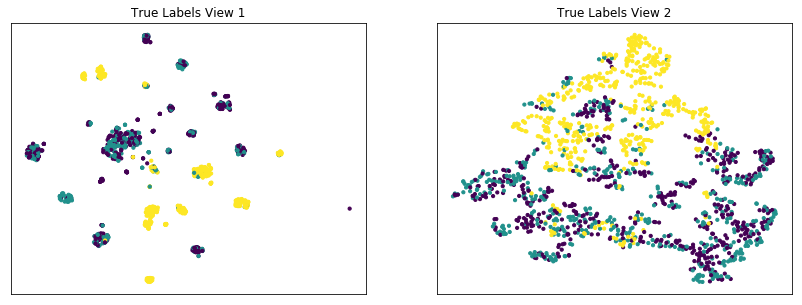

<Figure size 432x288 with 0 Axes>

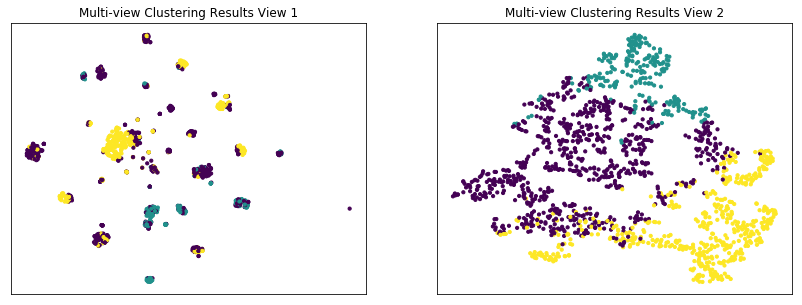

In [7]:
data, labels = get_cd_data()
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 3)

# Running TSNE to display clustering results via low dimensional embedding
tsne = TSNE()
new_data = list()
new_data.append(tsne.fit_transform(data[0]))
new_data.append(tsne.fit_transform(data[1]))
display_plots('True Labels', new_data, labels)
display_plots('Multi-view Clustering Results', new_data, m_clusters)

##### Evaluating the performance of Multi-view and Single-view KMeans clustering on other complex data

To see the relative performance of single-view and multi-view clustering on complex, real world data, please refer to the MultiviewKMeans_Tutorial notebook, which illustrates the application of both of these clustering methods to the UCI Digits Multiple Features Dataset. In this notebook, we can see that multi-view kmeans clustering produces clusters with higher purity than the single-view analogs when given informative views of data, even if conditional independence is not strictly enforced.